In [2]:
import numpy as np
import pandas as pd
import csv
import random
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import mpl_toolkits
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
import networkx as nx 

In [5]:
import os
os.chdir('F:/MSTER/network/project/U.S_Domestic_Flight_Nework_Analysis/data')

In [6]:
data=pd.read_csv('./flight_edges.tsv', sep='\t',header=None)
names = data.columns.tolist()
names[0]='departure'
names[1]='arrival'
names[9]='dep_pop'
names[10]='ari_pop'
data.columns = names

In [7]:
#extract records in 2009
newdata=data[(data[:][8]>=200901)&data[:][6]>0]
newdata1=newdata.loc[:,[0,1,6]]
newdata2=newdata1.groupby([0,1])[6].sum()
newdata3=newdata2.reset_index()

C:\Users\zhuns\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


## 1.visulization

In [8]:
# import graphic and compute scores of nodes importance
G=nx.read_weighted_edgelist('./flights.csv',delimiter=',',create_using=nx.DiGraph())
edgelist=pd.read_csv('./flights.csv', delimiter=',')
pr=nx.pagerank(G,weight=G.edges(data=True))
Hits = nx.hits(G)
hubs = Hits[0]
Authorities = Hits[1]
hubsframe=pd.DataFrame.from_dict(hubs,orient='index')
Authoritiesframe=pd.DataFrame.from_dict(Authorities,orient='index')
hubsframe.to_csv('./hubs.csv')
Authoritiesframe.to_csv('./Authorities.csv')


In [9]:
print('the graph has %d nodes' %(G.number_of_nodes()))

the graph has 518 nodes


In [10]:
#import airport geographic dataset
Airport=pd.read_csv('./Airport_la.csv', delimiter=',')
Airport=Airport.drop_duplicates()
PR=pd.read_csv('./PR.csv', delimiter=',')
HUBS=pd.read_csv('./hubs.csv', delimiter=',')
HUBS.columns = ['LocationId','HUBS']
AUTHOR=pd.read_csv('./Authorities.csv', delimiter=',')
AUTHOR.columns = ['LocationID','Authorities']
AUTHOR.head()

,LocationID,Authorities
0,1B1,1.026050e-07
1,BDL,6.093635e-03
2,ABE,1.628307e-03
3,ACT,6.071337e-04
4,ATL,3.828952e-02


In [11]:
float(PR[(PR['locationID']=='ABE')]['PageRank'].values)
AirportPR=PR.merge(Airport,on='locationID').drop_duplicates(subset=['locationID'])

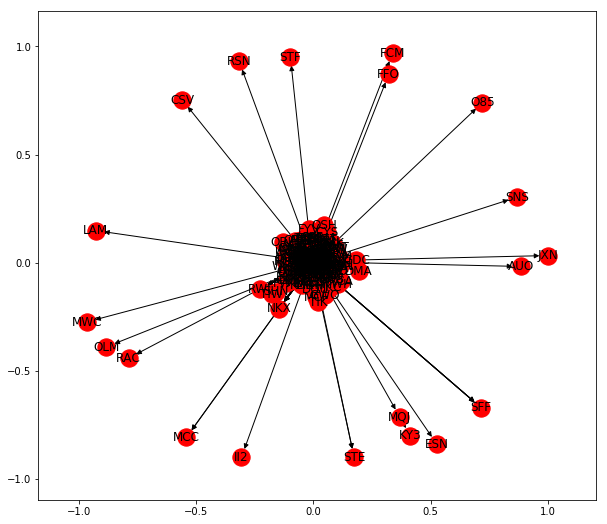

In [12]:
subG=G.subgraph(list(AirportPR[:]['locationID']))
plt.figure(figsize = (10,9))
nx.draw_networkx(subG)

C:\Users\zhuns\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


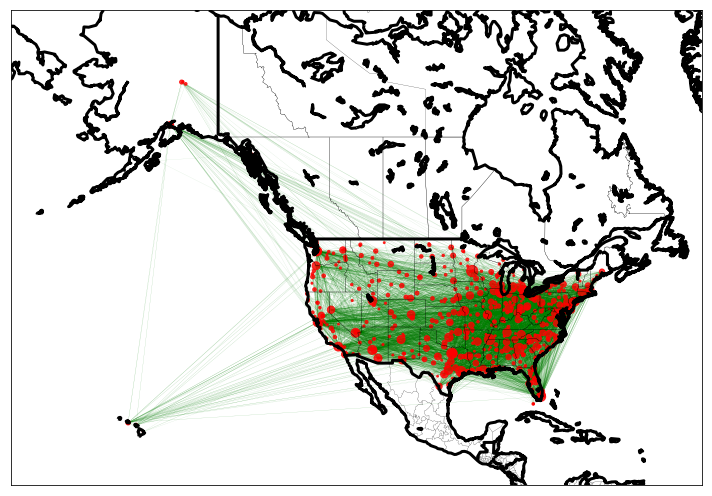

In [13]:
#plot based on PageRank
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
mx, my = m(AirportPR['Longtitude'].values, AirportPR['Latitude'].values)
pos = {}
for count, elem in enumerate (AirportPR['locationID']):
     pos[elem] = (mx[count], my[count])
nx.draw_networkx_nodes(subG, pos = pos, node_list = subG.nodes(), node_color = 'r', alpha = 0.8, node_size = [float(PR[(PR['locationID']==s)]['PageRank'].values)*10000 for s in subG.nodes()])
nx.draw_networkx_edges(subG, pos = pos, width=0.2,edge_color='g', alpha=0.2, arrows = False)
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.tight_layout()
plt.show()

C:\Users\zhuns\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


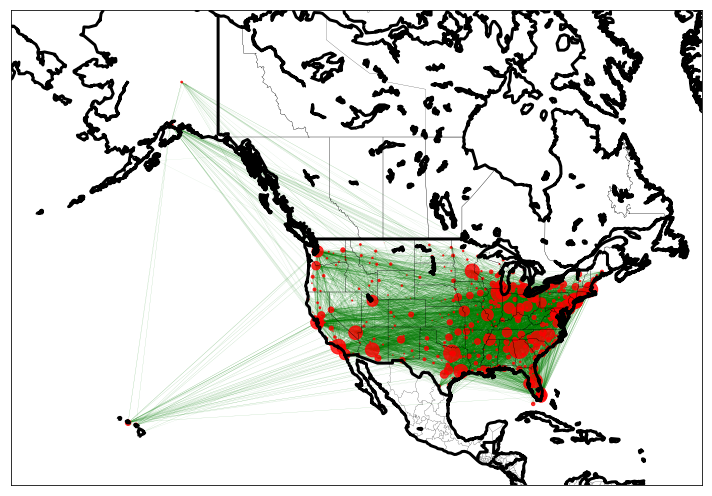

In [14]:
#plot based on Authorities
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
mx, my = m(AirportPR['Longtitude'].values, AirportPR['Latitude'].values)
pos = {}
for count, elem in enumerate (AirportPR['locationID']):
     pos[elem] = (mx[count], my[count])
nx.draw_networkx_nodes(subG, pos = pos, node_list = subG.nodes(), node_color = 'r', alpha = 0.8, node_size = [float(AUTHOR[(AUTHOR['LocationID']==s)]['Authorities'].values)*10000 for s in subG.nodes()])
nx.draw_networkx_edges(subG, pos = pos, width=0.2,edge_color='g', alpha=0.2, arrows = False)
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.tight_layout()
plt.show()

C:\Users\zhuns\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


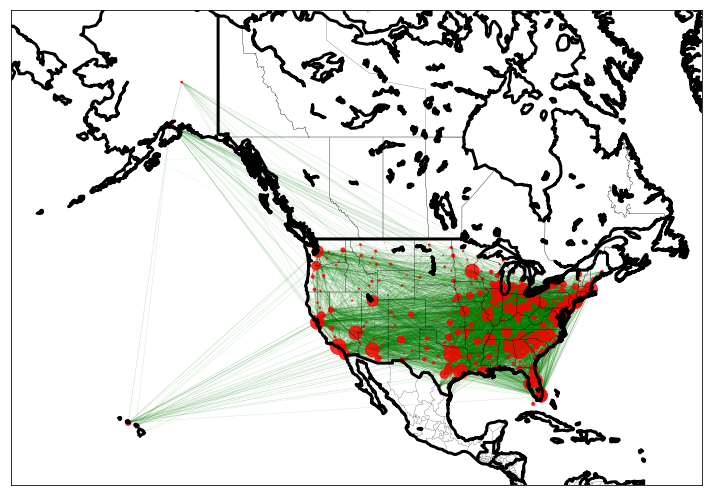

In [15]:
#plot based on HUBS
plt.figure(figsize = (10,9))
m = Basemap(projection='merc',llcrnrlon=-180,llcrnrlat=10,urcrnrlon=-50,urcrnrlat=70, lat_ts=0, resolution='l',suppress_ticks=True)
mx, my = m(AirportPR['Longtitude'].values, AirportPR['Latitude'].values)
pos = {}
for count, elem in enumerate (AirportPR['locationID']):
     pos[elem] = (mx[count], my[count])
nx.draw_networkx_nodes(subG, pos = pos, node_list = subG.nodes(), node_color = 'r', alpha = 0.8, node_size = [float(HUBS[(HUBS['LocationId']==s)]['HUBS'].values)*10000 for s in subG.nodes()])
nx.draw_networkx_edges(subG, pos = pos, width=0.2,edge_color='g', alpha=0.2, arrows = False)
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.tight_layout()
plt.show()

In [22]:
# Set number of flights as weight, last five year flights as  edges
# newdata=data[data[:][6]>0]
traindata=data[(data[:][8]>=200801)&data[:][6]>0&(data[:][8]<=200812)]
traindata1=traindata.iloc[:,[0,1]]
traindata2=traindata1.drop_duplicates()
# traindata2.to_csv('./edges08.csv',index=False)
testdata=data[(data[:][8]>=200901)&data[:][6]>0&(data[:][8]<=200912)]
testdata1=testdata.iloc[:,[0,1]]
testdata2=testdata1.drop_duplicates()
# testdata2.to_csv('./edges09.csv',index=False)
data1=data[data[:][6]>0]
data2=data1.iloc[:,[0,1]]
data3=data2.drop_duplicates()
# data3.to_csv('./edges.csv',index=False)

## 2. working on important nodes

In [23]:
#constract network for 2008 and 2009
G=nx.read_edgelist('./edges.csv', delimiter=',',create_using=nx.Graph())
# nodes=pd.DataFrame(list(G.nodes()))
# # nodes.to_csv('./all_nodes.csv',index=False)
G08=nx.read_edgelist('./edges08.csv', delimiter=',',create_using=nx.Graph())
G09=nx.read_edgelist('./edges09.csv', delimiter=',',create_using=nx.Graph())
G08.add_nodes_from(G.nodes(data=True))
G09.add_nodes_from(G.nodes(data=True))
edges08=pd.DataFrame(list(G08.edges()))
edges09=pd.DataFrame(list(G09.edges()))
non_edges08=pd.DataFrame(nx.non_edges(G08))
non_edges09=pd.DataFrame(nx.non_edges(G09))
edges08.columns = ['Departure','locationID']
edges09.columns = ['Departure','locationID']
non_edges08.columns = ['Departure','locationID']
non_edges09.columns = ['Departure','locationID']
edges08['label']=1
edges09['label']=1
non_edges08['label']=0
non_edges09['label']=0
train08=pd.concat([edges08,non_edges08])
test09=pd.concat([edges09,non_edges09])


In [24]:
train_data = np.array(train08)
train08=train_data.tolist()
test_data = np.array(test09)
test09=train_data.tolist()

In [25]:
#The population of the cities of the airports
airports_population = {}
for i in range(len(data)):
        airports_population[str(data['departure'].iloc[i])] = data['dep_pop'].iloc[i]
        airports_population[str(data['arrival'].iloc[i])] = data['ari_pop'].iloc[i]

airports_populations = []
airports_population_keys = list(airports_population.keys())
airports_population_values = list(airports_population.values())
for i in range(len(airports_population)):
    airports_populations.append([airports_population_keys[i],airports_population_values[i]])

In [26]:
class find_sort():
    def __init__(self, fname):
        self.sortidx = np.argsort(list(fname.values()))[::-1][:10]
        self.sort = []
        for i in list(self.sortidx):
            self.sort.append(list(fname.items())[i])
            

In [27]:
predsPgrank = nx.pagerank(G08)
Hits = nx.hits(G08)
predshubs = Hits[0]
predsAuthorities = Hits[1]
Clu=nx.clustering(G08)
betweenness = nx.betweenness_centrality(G08)
closeness = nx.closeness_centrality(G)

In [28]:
pr = find_sort(predsPgrank)
pr_sort=np.array(pr.sort)
print('#'*40)
print('10 highest pagerank nodes are')
print(pr_sort)
print('#'*40)
 

########################################
10 highest pagerank nodes are
[['YIP' '0.008795842034916013']
 ['MSP' '0.007812105056143729']
 ['ATL' '0.007766857158963251']
 ['MIA' '0.007416003887872233']
 ['MEM' '0.007355270736938677']
 ['PHX' '0.007341372171051673']
 ['IAD' '0.0072863435563846335']
 ['ORD' '0.007245059555747355']
 ['MCI' '0.007201871285859172']
 ['LAX' '0.006789150826597069']]
########################################


In [29]:
     
hubs = find_sort(predshubs)
hubs.sort
hubs_sort=np.array(hubs.sort)
print('#'*40)
print('10 highest hubs nodes are')
print(hubs_sort)
print('#'*40)

########################################
10 highest hubs nodes are
[['ATL' '0.007901869046840303']
 ['ORD' '0.007672732626762116']
 ['MEM' '0.007655220116571366']
 ['MSP' '0.007583940242594392']
 ['CLE' '0.007286783709968738']
 ['BNA' '0.00718337801098355']
 ['DTW' '0.007174607227843286']
 ['DFW' '0.007156997703402771']
 ['MCI' '0.007122753790511512']
 ['IAD' '0.007095768993300266']]
########################################


In [30]:
auth = find_sort(predsAuthorities)
auth_sort=np.array(auth.sort)
print('#'*40)
print('10 highest authorities nodes are')
print(auth_sort)
print('#'*40)

########################################
10 highest authorities nodes are
[['ATL' '0.007901869046813798']
 ['ORD' '0.007672732626762678']
 ['MEM' '0.007655220116560379']
 ['MSP' '0.0075839402426127675']
 ['CLE' '0.007286783709939376']
 ['BNA' '0.007183378010959069']
 ['DTW' '0.00717460722783195']
 ['DFW' '0.007156997703418299']
 ['MCI' '0.007122753790527705']
 ['IAD' '0.007095768993289341']]
########################################


In [31]:
clu = find_sort(Clu)
clu.sort
clu_sort=np.array(clu.sort)
print('#'*40)
print('10 highest clustering coefficient nodes are')
print(clu_sort)
print('#'*40)

########################################
10 highest clustering coefficient nodes are
[['WQM' '1.0']
 ['AMK' '1.0']
 ['NJK' '1.0']
 ['UVA' '1.0']
 ['MRI' '1.0']
 ['STE' '1.0']
 ['IMT' '1.0']
 ['AST' '1.0']
 ['HVR' '1.0']
 ['JEF' '1.0']]
########################################


## 3.link prediction

In [32]:
# random select node pairs in 2008 as traning set and in 2009 as testing set
to_keep = random.sample(range(len(train08)), k=int(round(len(train08)*0.05)))
training_set_reduced = [train08[i] for i in to_keep]
to_keep_test = random.sample(range(len(test09)), k=int(round(len(test09)*0.05)))
test_set_reduced = [test09[i] for i in to_keep_test]
# add population of arrival airport as feature
population = []
for element in training_set_reduced:
    population.append(airports_population[element[1]])
population_test = []
for element in test_set_reduced:
    population_test.append(airports_population[element[1]])

In [ ]:
#extracting centrality features

In [33]:
#betweenness centrality
counter=0   
def betweenness_predictor(G,ebunch=None):
    global counter
    counter += 1
    if ebunch is None:
        ebunch = nx.non_edges(G)
    u = ebunch[0][0]
    v = ebunch[0][1]
    # results generation
    bc_score = bc_[v]
    return ((u, v, bc_score) for u, v in ebunch)

In [34]:
#closeness centrality
counter=0    
def closeness_predictor(G,ebunch=None):
    global counter
    counter += 1
    if ebunch is None:
        ebunch = nx.non_edges(G)
    u = ebunch[0][0]
    v = ebunch[0][1]
    # results generation
    cc_score = cc_[v]
    return ((u, v, cc_score) for u, v in ebunch)

In [35]:
#pgrank with Random Walks Restart implementation
counter = 0
def random_walk_restart(G, ebunch=None):
    global counter
    counter += 1
    if ebunch is None:
        ebunch = nx.non_edges(G)
    u = ebunch[0][0]
    v = ebunch[0][1]
    tol = 1.0e-5  # can be modified
    alpha = 0.85  # can be modified
    M = nx.adjacency_matrix(G)
    counter += 1

    # converting adjacency matrix to transition matrix
    for i in range(M.shape[1]):
        if(np.sum(M[i]) > 0):
            M[i] = M[i]/np.sum(M[i])

    # defining start vector
    key_dict = {k: v for k, v in zip(list(G.nodes()), list(range(G.order())))}
    pu_o = [0] * G.order()
    su = [0] * G.order()
    su[key_dict[u]] = 1
    # pv_o[key_dict[u]] = 1
    pu_i = pu_o
    pv_o = [0] * G.order()
    sv = [0] * G.order()
    sv[key_dict[v]] = 1
    # pv_o[key_dict[v]] = 1
    pv_i = pv_o

    # iterations to generate probability vector
    iterator = 100  # can be modified
    for j in range(iterator):
        pu_f = np.multiply(alpha, M.T * pu_i) + np.multiply((1 - alpha), su)
        err = sum([abs(pu_f[n]-pu_i[n]) for n in range(len(pu_i))])
        if err < tol:
            break
        pu_i = pu_f

    for k in range(iterator):
        pv_f = np.multiply(alpha, M.T * pv_i) + np.multiply((1 - alpha), sv)
        err = sum([abs(pv_f[n]-pv_i[n]) for n in range(len(pv_i))])
        if err < tol:
            break
        pv_i = pv_f

    # results generation
    rwr_score = pu_f[key_dict[v]] + pv_f[key_dict[u]]
    return ((u, v, rwr_score) for u, v in ebunch)

In [36]:
# pagerank with Local Random Walks (LRW) implementation
counter = 0
def local_random_walk(G, ebunch=None):
    global counter
    counter += 1
    if ebunch is None:
        ebunch = nx.non_edges(G)
    u = ebunch[0][0]
    v = ebunch[0][1]
    alpha = 0.85  # can be modified
    M = nx.adjacency_matrix(G)
    counter += 1

    # converting adjacency matrix to transition matrix
    for i in range(M.shape[1]):
        if(np.sum(M[i]) > 0):
            M[i] = M[i]/np.sum(M[i])

    # defining start vector
    key_dict = {k: v for k, v in zip(list(G.nodes()), list(range(G.order())))}
    pu_o = [0] * G.order()
    su = [0] * G.order()
    su[key_dict[u]] = 1
    # pv_o[key_dict[u]] = 1
    pu_i = pu_o
    pv_o = [0] * G.order()
    sv = [0] * G.order()
    sv[key_dict[v]] = 1
    # pv_o[key_dict[v]] = 1
    pv_i = pv_o

    # iterations to generate probability vector
    iterator = 10  # can be modified IMPORTANT !!!!
    for j in range(iterator):
        pu_f = np.multiply(alpha, M.T * pu_i) + np.multiply((1 - alpha), su)
        pu_i = pu_f

    for k in range(iterator):
        pv_f = np.multiply(alpha, M.T * pv_i) + np.multiply((1 - alpha), sv)
        pv_i = pv_f

    # results generation
    lrw_score = (len(G[u]) * pu_f[key_dict[v]] + len(G[v]) * pv_f[key_dict[u]])/(2 * G.size())
    return ((u, v, lrw_score) for u, v in ebunch)

In [37]:
#propflow scores
def propflow_predictor(G, ebunch=None):
    global counter
    counter += 1
    if ebunch is None:
        ebunch = nx.non_edges(G)
    u = ebunch[0][0]
    v = ebunch[0][1]
    l = 10  # can be modified

    # defining start vector
    key_dict = {k: v for k, v in zip(list(G.nodes()), list(range(G.order())))}
    s = [0] * G.order()
    s[key_dict[u]] = 1
    found = [u]
    new_search = [u]
    for current_degree in range(l):
        old_search = new_search
        new_search = []
        for i in old_search:
            for j in G.neighbors(i):
                s[key_dict[j]] += s[key_dict[i]]/len(list(G.neighbors(i)))
                if j not in found:
                    found.append(j)
                    new_search.append(j)

    # results generation
    pfp_score = s[key_dict[v]]
    return ((u, v, pfp_score) for u, v in ebunch)

In [38]:
# find out best centrality based method of link prediction
def ROCevaluator(LP_function):
    secure_random = random.SystemRandom()
    iterator = int(100)  # iterator = int(0.1 * len(edges))
    n_greater = 0  # no. of times edge score is > than non-edge score
    n_equal = 0  # no. of times edge score is = than non-edge score
    n_less = 0  # no. of times edge score is < than non-edge score
    auc = 0.0  # AUROC score value
    for i in range(iterator):
        random_edge = secure_random.choice(list(G09.edges()))
        random_non_edge = secure_random.choice(list(nx.non_edges(G09)))
        itr1 = LP_function(G09, [random_edge])
        itr2 = LP_function(G09, [random_non_edge])
        for j in itr1:
            temp1 = j
        score_edge = temp1[2]
        for k in itr2:
            temp2 = k
        score_non_edge = temp2[2]
        if score_edge > score_non_edge:
            n_greater += 1
        elif score_edge == score_non_edge:
            n_equal += 1
        else:
            n_less += 1
    auc = (n_greater + 0.5 * n_equal)/iterator  # print 'AUC = %f' % auc
    return auc

In [39]:
bc_ = nx.betweenness_centrality(G09)
roc_BC = ROCevaluator(betweenness_predictor)
print ('AUC for betweenness centrality Predictor (BC) = %f' % roc_BC)
print ('counter value = %d' % counter)

AUC for betweenness centrality Predictor (BC) = 0.870000
counter value = 200


In [40]:
cc_ = nx.closeness_centrality(G09)
roc_CC = ROCevaluator(closeness_predictor)
print ('AUC for betweenness Predictor (BT) = %f' % roc_CC)
print ('counter value = %d' % counter)
counter = 0

AUC for betweenness Predictor (BT) = 0.860000
counter value = 400


In [41]:
roc_PFP = ROCevaluator(propflow_predictor)
print ('AUC for PropFlow Predictor (PFP) = %f' % roc_PFP)
print ('counter value = %d' % counter)
counter = 0

AUC for PropFlow Predictor (PFP) = 0.990000
counter value = 200


In [42]:
roc_RWR = ROCevaluator(random_walk_restart)
print ('AUC for Random Walks Restart = %f' % roc_RWR)
print ('counter value = %d' % counter)
counter = 0

AUC for Random Walks Restart = 0.505000
counter value = 400


In [43]:
roc_LRW= ROCevaluator(local_random_walk)
print ('AUC for Local Random Walks (LRW) = %f' % roc_LRW)
print ('counter value = %d' %counter)
counter = 0

AUC for Local Random Walks (LRW) = 0.525000
counter value = 400


In [44]:
#features extraction

scorecluster = []
scorehubs=[]
scoreAuthor=[]
scoreJac=[]
scorePref=[]
scoreBC=[]
scoreCC=[]
scoreRWR=[]
scoreLWR=[]
scorePF=[]

In [45]:
for i in range(len(training_set_reduced)):
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1]
    
    source_cluster = Clu.get(source)
    target_cluster = Clu.get(target)
    cluster_total=source_cluster+target_cluster
    
    scorecluster.append(cluster_total)
    scorehubs.append(predshubs[target])
    scoreAuthor.append(predsAuthorities[source])

In [47]:
#find node paire in traing_set_reduced
node_pair_train=[(element[0],element[1]) for element in training_set_reduced]
#betweenness centrality
bc = betweenness_predictor(G08,node_pair_train)
#closeness centrality
cc = closeness_predictor(G08,node_pair_train)
#random walk with restart scores
rwr = random_walk_restart(G08,node_pair_train)
#local random walk scores
lwr = local_random_walk(G08,node_pair_train)
#propflow scores
pf = propflow_predictor(G08,node_pair_train)
# Neighborhood-based Methods
predsJac = nx.jaccard_coefficient(G08,node_pair_train)
predsPref = nx.preferential_attachment(G08,node_pair_train)

In [48]:
for u, v, p in predsJac:
    scoreJac.append(p)
for u, v, p in predsPref:
    scorePref.append(p)
for u, v, p in bc:
    scoreBC.append(p)
for u, v, p in cc:
    scoreCC.append(p)
for u, v, p in rwr:
    scoreRWR.append(p)
for u, v, p in lwr:
    scoreLWR.append(p)
for u, v, p in pf:
    scorePF.append(p)
training_features = np.array([scorehubs,scoreAuthor,scorecluster,scoreJac,scorePref,scorePF,population]).T
# scale
training_features = preprocessing.scale(training_features)
#np.savetxt('training_features.csv', training_features, delimiter = ',')
training_labels = [element[2] for element in training_set_reduced]
training_labels = np.array(training_labels)

C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [49]:
training_features.shape

(13202, 7)

In [50]:
scorecluster_test = []
scorehubs_test=[]
scoreAuthor_test=[]



In [51]:
for i in range(len(test_set_reduced)):
    source = test_set_reduced[i][0]
    target = test_set_reduced[i][1]
    
    source_cluster = Clu.get(source)
    target_cluster = Clu.get(target)
    cluster_total_test=source_cluster+target_cluster
    
    scorecluster_test.append(cluster_total_test)
    scorehubs_test.append(predshubs[target])
    scoreAuthor_test.append(predsAuthorities[source])

In [52]:
#find node paire in traing_set_reduced
node_pair_test=[(element[0],element[1]) for element in test_set_reduced]
#betweenness centrality
bc_test= betweenness_predictor(G08,node_pair_test)
#closeness centrality
cc_test= closeness_predictor(G08,node_pair_test)
#random walk with restart scores
rwr_test= random_walk_restart(G08,node_pair_test)
#local random walk scores
lwr_test= local_random_walk(G08,node_pair_test)
#propflow scores
pf_test= propflow_predictor(G08,node_pair_test)
# Neighborhood-based Methods
predsJac_test = nx.jaccard_coefficient(G09,node_pair_test)
predsAdar_test = nx.adamic_adar_index(G09,node_pair_test)
predsPref_test = nx.preferential_attachment(G09,node_pair_test)

In [53]:
scoreJac_test=[]
scorePref_test=[]
scoreBC_test=[]
scoreCC_test=[]
scoreRWR_test=[]
scoreLWR_test=[]
scorePF_test=[]

In [54]:
for u, v, p in predsJac_test:
    scoreJac_test.append(p)
for u, v, p in predsPref_test:
    scorePref_test.append(p)
for u, v, p in bc_test:
    scoreBC_test.append(p)
for u, v, p in cc_test:
    scoreCC_test.append(p)
for u, v, p in rwr_test:
    scoreRWR_test.append(p)
for u, v, p in lwr_test:
    scoreLWR_test.append(p)
for u, v, p in pf_test:
    scorePF_test.append(p)
testing_features = np.array([scorehubs_test,scoreAuthor_test,scorecluster_test,scoreJac_test,scorePref_test,scorePF_test,population_test]).T
# scale
testing_features = preprocessing.scale(testing_features)
#np.savetxt('training_features.csv', training_features, delimiter = ',')
testing_labels = [element[2] for element in test_set_reduced]
testing_labels = np.array(testing_labels)

In [55]:
# build models
# initialize basic SVM
SVC = svm.LinearSVC()
# initialize basic Decision tree
DT = DecisionTreeClassifier()
# initialize basic Random forest
RF = RandomForestClassifier()
# initialize Extreme Gradient Boosting Classifier
XGB = XGBClassifier()
# initialize Balanced Bagging Classifier
BB = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion='entropy'), n_estimators = 5, bootstrap = True)
# train
SVC.fit(training_features, training_labels)
DT.fit(training_features, training_labels)
RF.fit(training_features, training_labels)
XGB.fit(training_features, training_labels)
BB.fit(training_features, training_labels)

C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default v

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
             bootstrap=True, bootstrap_features=False, max_features=1.0,
             max_samples=1.0, n_estimators=5, n_jobs=1, oob_score=False,
             random_state=None, ratio=None, replacement=False,
             sampling_strategy='auto', verbose=0, warm_start=False)

In [56]:
#model evaluation
def prepare_kfold_cv_data(k,X,y):
    kf = KFold(n_splits=k, shuffle=False, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

models_dictionary = OrderedDict()

models_dictionary['Support Vector'] = SVC
models_dictionary['Decision Tree'] = DT
models_dictionary['Random Forest'] = RF
models_dictionary['Extrme Gradieng Boosting'] = XGB
models_dictionary['Balanced Bagging'] = BB

def perform_data_modeling(_models_, k_folds = 5):
    for model_name,clf in _models_.items():
        print('model'+model_name+'\033[0m')
        X_train_list,y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds,training_features, training_labels)
        F1_score = 0
        for k_index in range(k_folds):
            X_train = X_train_list[k_index]
            y_train = y_train_list[k_index]
            X_test = X_test_list[k_index]
            y_test = y_test_list[k_index]
            
            #fit the model
            clf = clf.fit(X_train, y_train)
            y_test_predicted = clf.predict(X_test)
            
            #calculating F1 score
            F1_score+=f1_score(y_test, y_test_predicted,average = 'binary')
        F1_score = F1_score/k_folds
        print(F1_score)

results=perform_data_modeling(models_dictionary,k_folds = 5 ) 

modelSupport Vector


C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

0.6152954774372557
modelDecision Tree
0.5604780171870782
modelRandom Forest
0.6158196533493571
modelExtrme Gradieng Boosting
0.6417445594764539
modelBalanced Bagging


C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuns\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

0.5038855779854857


In [57]:
test_prediction = XGB.predict(testing_features)
test_result = pd.concat([pd.DataFrame(test_set_reduced).iloc[:,:2],pd.DataFrame(test_prediction)],axis = 1)
